# Setup

In [10]:
import torch
from torchvision import datasets, transforms 
from sklearn.metrics import classification_report

In [11]:
%run setup.ipynb 

# Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.

Batch size: 16, epochs: 50, optimizer: Adam 

## Augmentation round 1

First, just gonna mess up the pictures a little - no sciency arguments for it other than intuitively trying to capture that the feeder images are more grainy and the birds are not always perfectly posed (hence the crop).

In [12]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation1 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=16, shuffle=True, num_workers=4)

In [13]:
# LOOKING AT THE AUGMENTATIONS 

# inputs, classes = next(iter(dataloader_train_aug1))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_labels[x] for x in classes])

Load in a fresh ResNet50 that's prepped for transfer learning and optimizer

In [14]:
untrained_model_aug1 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(untrained_model_aug1.parameters(), lr=0.001)
#optimizer = get_optimizer(untrained_model_aug1)

### Training

In [15]:
trained_model_aug1, trained_aug1_info = train_model(model=untrained_model_aug1, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug1)

Epoch 1/50
----------
Train Loss: 1.6094 Acc: 0.5138
Val Loss: 1.3481 Acc: 0.6635
Epoch time 2m 35s
----------

Epoch 2/50
----------
Train Loss: 1.1025 Acc: 0.7701
Val Loss: 1.0547 Acc: 0.8462
Epoch time 2m 33s
----------

Epoch 3/50
----------
Train Loss: 0.8566 Acc: 0.8407
Val Loss: 0.8686 Acc: 0.9038
Epoch time 2m 34s
----------

Epoch 4/50
----------
Train Loss: 0.7307 Acc: 0.8503
Val Loss: 0.7642 Acc: 0.9038
Epoch time 2m 34s
----------

Epoch 5/50
----------
Train Loss: 0.6585 Acc: 0.8623
Val Loss: 0.6696 Acc: 0.9135
Epoch time 2m 35s
----------

Epoch 6/50
----------
Train Loss: 0.5579 Acc: 0.8826
Val Loss: 0.6187 Acc: 0.9519
Epoch time 2m 34s
----------

Epoch 7/50
----------
Train Loss: 0.5136 Acc: 0.9006
Val Loss: 0.5741 Acc: 0.9135
Epoch time 2m 35s
----------

Epoch 8/50
----------
Train Loss: 0.4632 Acc: 0.9102
Val Loss: 0.5107 Acc: 0.9327
Epoch time 2m 35s
----------

Epoch 9/50
----------
Train Loss: 0.4582 Acc: 0.9018
Val Loss: 0.4705 Acc: 0.9327
Epoch time 2m 35s
----

In [16]:
torch.save({"aug": trained_model_aug1.state_dict(), "aug_info": trained_aug1_info},"aug1Model_50.tar")

### Training Results

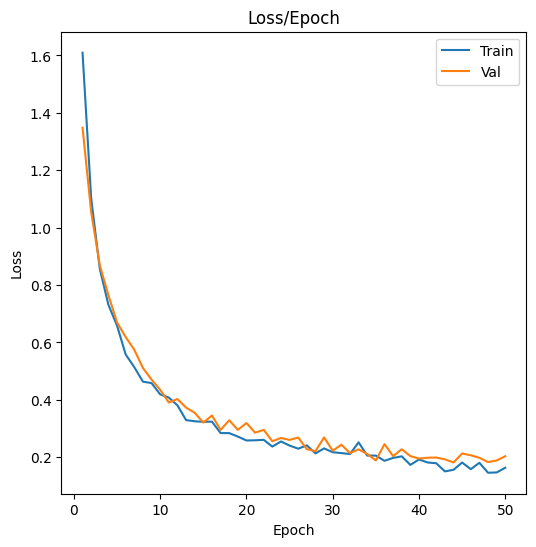

In [17]:
plot_loss(trained_aug1_info["train_loss"], trained_aug1_info["val_loss"], ["Train", "Val"])

In [18]:
truel, predl = makeAll(dataloader_test, trained_model_aug1, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

Accuracy:  95.23809523809523
              precision    recall  f1-score   support

     blueTit       0.94      1.00      0.97        15
   chaffinch       0.83      1.00      0.91        15
     coalTit       1.00      0.93      0.97        15
   goldfinch       1.00      0.93      0.97        15
    greatTit       1.00      0.93      0.97        15
       robin       1.00      0.87      0.93        15
    starling       0.94      1.00      0.97        15

    accuracy                           0.95       105
   macro avg       0.96      0.95      0.95       105
weighted avg       0.96      0.95      0.95       105



### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug1)
model_aug1, model_aug1_info = train_model(model=trained_model_aug1, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug1)

In [ ]:
torch.save({"aug1": model_aug1.state_dict(), "aug1_info": model_aug1_info, "freeze_aug1_info": trained_aug1_info},"aug1Model_60.tar")

### Round 1 results

In [ ]:
visualize_model(model_aug1, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug1_info["train_loss"], model_aug1_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug1_info["train_acc"], model_aug1_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


In [ ]:
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


## Augmentation Round 2

Add blur and colorjitter

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation2 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1), # Added
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug2 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation2)
dataloader_train_aug2 = torch.utils.data.DataLoader(dataset_train_aug2, batch_size=16, shuffle=True, num_workers=2)

Load in a fresh ResNet50 that's prepped for transfer learning

In [ ]:
untrained_model_aug2 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(untrained_model_aug2.parameters(), lr=0.001)
#optimizer = get_optimizer(untrained_model_aug2) 

### Training

In [ ]:
trained_model_aug2, trained_aug2_info = train_model(model=untrained_model_aug2, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug2) 

In [ ]:
torch.save({"aug": trained_model_aug2.state_dict(), "aug_info": trained_aug2_info},"aug2Model_50.tar")

### Training Results

In [ ]:
plot_loss(trained_aug2_info["train_loss"], trained_aug2_info["val_loss"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, trained_model_aug2, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug2)
model_aug2, model_aug2_info = train_model(model=trained_model_aug2, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug2)

In [ ]:
torch.save({"aug2": model_aug2.state_dict(), "aug2_info": model_aug2_info, "freeze_aug1_info": trained_aug2_info},"aug2Model_40.tar")

### Round 2 Results

In [ ]:
visualize_model(model_aug2, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug2_info["train_loss"], model_aug2_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug2_info["train_acc"], model_aug2_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

## Augmentation round 3

Try without jitter

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug3 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation3)
dataloader_train_aug3 = torch.utils.data.DataLoader(dataset_train_aug3, batch_size=16, shuffle=True, num_workers=2)

Load in a fresh ResNet50 that's prepped for transfer learning

In [ ]:
untrained_model_aug3 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(untrained_model_aug3.parameters(), lr=0.001)
# optimizer = get_optimizer(untrained_model_aug3) 

### Training
First with the frozen layers, then unfreeze for finetuning

In [ ]:
trained_model_aug3, trained_aug3_info = train_model(model=untrained_model_aug3, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug3) 

In [ ]:
torch.save({"aug": trained_model_aug3.state_dict(), "aug_info": trained_aug3_info},"aug3Model_50.tar")

### Training Results

In [ ]:
plot_loss(trained_aug3_info["train_loss"], trained_aug3_info["val_loss"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, trained_model_aug3, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug3)
model_aug3, model_aug3_info = train_model(model=trained_model_aug3, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug3)

In [ ]:
torch.save({"aug3": model_aug3.state_dict(), "aug3_info": model_aug3_info, "freeze_aug3_info": trained_aug3_info},"aug3Model_40.tar")

### Round 3 Results

In [ ]:
visualize_model(model_aug3, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug3_info["train_loss"], model_aug3_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug3_info["train_acc"], model_aug3_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

### On Feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))